<a href="https://colab.research.google.com/github/xia0405/Master-thesis-NLP/blob/master/Sentiment_analysis_Amazon_Reviews_Polarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMAZON REVIEWS

This notebook will use pre-trained language model and fine tune on the Amazon dataset.   
The notebook is provided by [Fastai github link](https://github.com/fastai/fastai/tree/master/courses/dl1).  
Fastai is a free deep learning course provided by Jeremy Howard.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
from fastai.text import *

## Preparing the data

This dataset consists of a few million Amazon customer reviews (input text) and star ratings (output labels). 

[dataset](https://https://www.kaggle.com/bittlingmayer/amazonreviews/kernels)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
#path = Path('/content/drive/My Drive/TextClassificationDatasets')
path = Path('/content/drive/My Drive/data/amazon')
path.mkdir(parents=True, exist_ok=True)
path.ls()

[PosixPath('/content/drive/My Drive/data/amazon/amazon_review_polarity_csv'),
 PosixPath('/content/drive/My Drive/data/amazon/smallSample_Amazon.csv'),
 PosixPath('/content/drive/My Drive/data/amazon/polarity_reviews.csv'),
 PosixPath('/content/drive/My Drive/data/amazon/train.csv'),
 PosixPath('/content/drive/My Drive/data/amazon/test.csv'),
 PosixPath('/content/drive/My Drive/data/amazon/accuracy_total.tsv'),
 PosixPath('/content/drive/My Drive/data/amazon/data_lm.pkl'),
 PosixPath('/content/drive/My Drive/data/amazon/models'),
 PosixPath('/content/drive/My Drive/data/amazon/data_clas.pkl')]

In [10]:
train = pd.read_csv(path/"train.csv")
test = pd.read_csv(path/"test.csv")
train.head()

,overall,reviewText
0,0,Didn't like the fact the numbers were stitched...
1,0,"While these did protect my carbon-soled shoes,..."
2,0,Mine was another roller cut in half. I could h...
3,0,"I have to agree with Plachno on this one, but ..."
4,0,"Second pair I have, this pair has an elastic b..."


In [11]:
print(f'Training length: {len(train)}, Test length: {len(test)}')

Training length: 160000, Test length: 40000


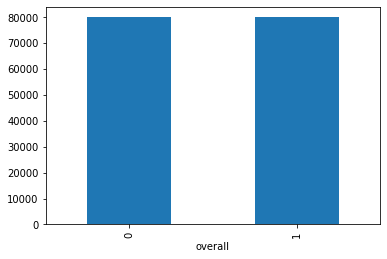

In [11]:
train.groupby('overall')['reviewText'].count().plot.bar()

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs = 48
# bs = 128

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [0]:
#df = pd.concat([train,test], sort=False)

In [16]:
data_lm = TextLMDataBunch.from_df(Path(path), train, test, text_cols='reviewText', bs = bs)

In [0]:
# Language model data
#data_lm = (TextList.from_df(df, cols='reviewText')
  #        .split_by_rand_pct(0.1, seed=42)
 #         .label_for_lm()
   #       .databunch(bs=bs, num_workers=1))

In [0]:
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [18]:
data_lm.show_batch()

idx,text
0,", i found it next to impossible to clip in . \n \n xxmaj my method : \n - xxmaj reach down , touch the pedal with my foot , toe slightly up \n - pull foot back , hooking the back of the cleat in the pedal \n - press down to fully engage \n \n xxmaj all this happens quickly , while pedaling"
1,. i ordered men size in hopes they would be plenty big on a woman ... not even close ! xxbos not as strong as i thought it would be xxbos xxmaj followed directions to a tee ! xxmaj fit nice but soon shrunk and stopped being of any use ! xxbos xxmaj this is not made for using as a means to hold up your pants . xxmaj in
2,"de - xxunk ( cheapened ) considerably since our first one , but it 's still available for about $ 125 , can be set up by two people in 5 - 10 minutes , keeps five of us dry with plenty of space , and has very good ventilation . \n \n xxmaj it is the unanimous opinion of the entire family that this tent , in comparison"
3,"off in my neighborhood . i figured it would be for a couple hours only so i pulled out my xxup three xxmaj coleman xxup led lanterns and my xxmaj core lantern . xxmaj of the xxmaj colemans , two had the rechargeable packs , and one the 4 d - xxmaj cell pack . xxmaj the xxmaj core lit great with no problems . xxmaj lit up the xxup"
4,have a pro do it xxbos i have had this reel for a couple of months now and have taken it fishing 4 times . i am an avid fisherman and very good at casting baitcasters . xxmaj each time i have taken this reel fishing i make sure i have it dialed in for the lure i am casting using the spool tension knob on the right side of


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [19]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


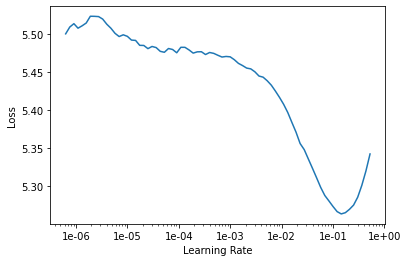

In [21]:
learn.recorder.plot(skip_end=15)

In [22]:
learn.fit_one_cycle(2, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.676901,4.443329,0.238066,08:02
1,4.223029,4.016422,0.270667,08:01


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.813717,3.728895,0.300580,09:13
1,3.692659,3.612109,0.314048,09:12
2,3.564636,3.543859,0.322824,09:13
3,3.464123,3.529900,0.324874,09:14


In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this product because"
N_WORDS = 40
N_SENTENCES = 2

In [28]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this product because it was not an ultralight worked up product by the process of taking it out of the box . The deflation feature is a big plus . Not a big deal , but very useful . It
I liked this product because of that . i bought this device for the range . i got a piece of plastic , it 's very bulky , and it was n't adjustable . When i got it on , it was almost impossible


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [9]:
data_clas = TextClasDataBunch.from_df(Path(path), train, test, text_cols='reviewText',vocab=data_lm.vocab, label_cols=0,bs=bs)


In [0]:
data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [11]:
data_clas.show_batch()

text,target
"xxbos i have used these mylar blankets on several occasions in emergency situations in the north of xxmaj scotland , and can really say that they are quite useless as a single item versus a taped mylar sleeping bag . xxmaj the latter has multiple survival uses ( sleeping bag , tent , large double - layered sun shade , wind - breaker , or fire / stove heat -",0
"xxbos i xxmaj just received this product today and without even taking it out to the range , i am despised that i was fooled by false advertising . xxmaj before i even start to discuss the abundance of reasons why this sight should never be purchased , i will even explain the reason why you should not trust this company , "" dagger defense "" . xxmaj simply put",0
"xxbos i have been using these on my daily commute for a year and they are still going strong . xxmaj they work in all conditions heat , cold , and rain . i would buy them again and have bought additional mounts so i can use it on my other bikes . \n \n xxmaj the headlight cycles through 5 settings : medium , high , low ,",1
"xxbos xxup review xxup of xxup the xxup second xxup one i xxup received : xxup four xxup stars : \n i stand by my original review listed below . xxmaj however i have received my replacement and after a few sessions at the range it is running strong and i really like the low profile . xxmaj again , installation and sighting it in was child 's play",1
"xxbos xxmaj week one rating ; i 'm one of those people who hate exercise , but recognize the need for it , i get bored real quick with routines . xxmaj this program will not allow you to get bored , in fact now i look forward to my work - out each day ( a first for me ) . i was in fair shape before starting ,",1


We can then create a model to classify those reviews and load the encoder we saved before.

In [15]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3).to_fp16()
learn_c.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (160000 items)
x: TextList
xxbos xxmaj did n't like the fact the numbers were stitched on and the stitching started coming apart the first time out . xxmaj got a refund .,xxbos xxmaj while these did protect my carbon - soled shoes , they caused me considerable problems clipping in . i had ridden eggbeaters for many years before buying these . xxmaj clipping in was second nature . xxmaj after installing these , i found it next to impossible to clip in . 
 
  xxmaj my method : 
  - xxmaj reach down , touch the pedal with my foot , toe slightly up 
  - pull foot back , hooking the back of the cleat in the pedal 
  - press down to fully engage 
 
  xxmaj all this happens quickly , while pedaling . xxmaj with these , my " pull back " hooks the pedal on the edge of the shield , instead of the cleat . 
 
  xxmaj it 's not necessarily a bad product , just not for me .,xxbos xxmaj mine was another roller cut in half . i could have done that m

In [0]:
from sklearn.metrics import f1_score


@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))



In [13]:
learn_c.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


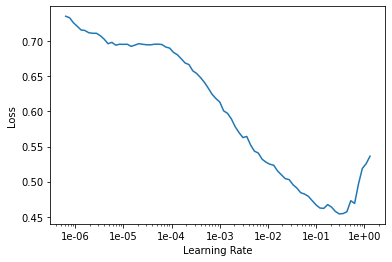

In [14]:
learn_c.recorder.plot()

In [15]:
learn_c.fit_one_cycle(2, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.259858,0.211440,0.915225,03:24
1,0.253027,0.201993,0.919550,03:39


In [0]:
learn_c.save('first')

In [0]:
learn_c.load('first');

In [18]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.236621,0.182684,0.926850,04:26
1,0.202866,0.172497,0.933475,03:58


In [19]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.187634,0.171542,0.933200,05:46
1,0.140232,0.145238,0.945775,06:39


In [20]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.107461,0.148461,0.947000,08:40


In [0]:
learn_c.save('final_class')

In [22]:
learn_c.predict("I will not buy it again!")

(Category tensor(0), tensor(0), tensor([0.9983, 0.0017]))

In [24]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.9470), tensor(0.9467, dtype=torch.float64))